In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns
import pandas as pd
from random import random
import json, os.path, pickle
import sys, time
from pathlib import Path
print(f"running python {sys.version}")

# condtional printing untility, only prints important messages
global verbosity
verbosity = 5
def pp(importance, message):
    if importance > 10-verbosity:
        print(message)



running python 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


In [2]:
# Configure testing variable based on fact that my kids windows pcs are more powerfult than my cheapo linux box
from sys import platform
testing = platform == 'linux'
print (f"we are {'' if testing else 'not '}on a testing computer")

we are not on a testing computer


Testing the learning curve mathematics based on three parameters.


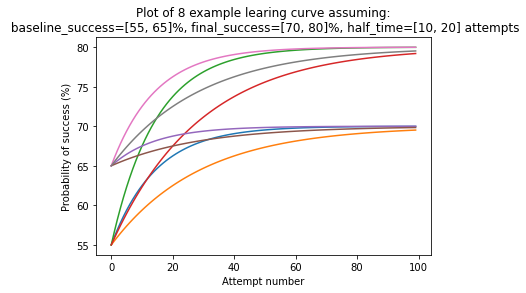

In [3]:
print("Testing the learning curve mathematics based on three parameters.")

def success_p(attempt, baseline_success, final_success, half_time):
    failure_risk = 0.5**(attempt/half_time) # in range 0 to 1
    return final_success - failure_risk *(final_success - baseline_success)

def plot_example_learning_curves():
    bs = [55, 65] # percent
    fs =[70,80] # percent
    ht = [10, 20]
    fig, ax = plt.subplots()
    for baseline_success in bs:
        for final_success in fs: # percent
            for half_time in ht: # cases
                x = np.array(range(0, 100))  
                y = success_p(attempt = x, baseline_success = baseline_success, final_success = final_success, half_time = half_time)
                plt.plot(x, y)  
    plt.title(f"Plot of {len(bs)*len(fs)*len(ht)} example learing curve assuming:\n baseline_success={bs}%, final_success={fs}%, half_time={ht} attempts")
    ax.set_ylabel('Probability of success (%)')
    ax.set_xlabel('Attempt number')
    plt.show()  

plot_example_learning_curves()

In [4]:
##
## Create a population of learning curves
## (as three seperate arrays of the defining parameters)
## 


"""
Make mock curves as defined by three lists of defining parameters:
* baseline success probablity (ie how well the student will do on first ever attempt)
* final sussess probability (ie how well this stuedent will eventually become)
* number of attempts to achieve half the improvement from baseline to final proficency
"""
def generate_student_curves(baseline_alpha, baseline_beta, fall_in_failure_rate, half_time_mean, n = 2000):
    #baseline_success_p = 1/(1+np.random.exponential(odds_of_failure,n))
    # see https://towardsdatascience.com/beta-distribution-intuition-examples-and-derivation-cf00f4db57af
    baseline_success_p = np.random.beta(baseline_alpha, baseline_beta,n)
    failure_p = 1-baseline_success_p # baseline risk of failure 
    final_success_p = 1-(failure_p * (1-fall_in_failure_rate*np.random.random(n)))
    attempts_to_half_improvement = np.random.rayleigh(half_time_mean,n)
    return {"bsp": baseline_success_p, "fsp": final_success_p, "athi": attempts_to_half_improvement}

""" 
Describe a set of student curves, and optionally plot.
Return a dictionary of values.                      
"""
def describe_student_curves(sc, meta, chattiness=1):
    pp(chattiness, f"""      
    baseline_success_p = {sc['bsp'].mean():0.2f} (sd: {sc['bsp'].std():0.2f})
    final_success_p = {sc['fsp'].mean():0.2f} (sd: {sc['fsp'].std():0.2f})
    attempts_to_half_improvement = {sc['athi'].mean():0.2f} (sd: {sc['athi'].std():0.2f})
    """)    
    return {
      **meta,
      "baseline_success_p": sc['bsp'].mean(),
      "baseline_success_p_sd": sc['bsp'].std(),     
      "final_success_p": sc['fsp'].mean(), 
      "final_success_p_sd": sc['fsp'].std(),
      "attempts_to_half_improvement": sc['athi'].mean(),
      "attempts_to_half_improvement_sd": sc['athi'].std(),
      "key": f"{sc['bsp'].mean():0.2f}_{sc['bsp'].std():0.2f}_{sc['fsp'].mean():0.2f}_{sc['fsp'].std():0.2f}_{sc['athi'].mean():0.2f}_{sc['athi'].std():0.2f}"
        }

def plot_student_curve(sc):
    n = len(sc['bsp'])
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 2))
    count, bins, ignored = ax0.hist(sc['bsp'], bins=100, density=True, alpha=0.6, label="Baseline")
    count, bins, ignored = ax0.hist(sc['fsp'], bins=100, density=True, alpha=0.6, range=(0,1), label="Final")
    ax0.axis((0,1,0,n/200))
    ax0.set_title("Distribution of student's success probability")
    ax0.set_xlabel('Probability of success')
    ax0.legend()
    ax0.set(yticklabels=[]) 
    count, bins, ignored = ax1.hist(sc['athi'], bins=100, density=False)
    ax1.set_title("Distribution of student's attempts\nto make half ultimate improvement")
    ax1.set_xlabel('Attempt number')
    ax1.set(yticklabels=[]) 
    fig.tight_layout()
    plt.show()

""" 
Implement the student curve by calculating the probability of success at a given attempt. 
""" 
def student_p(student_id, attempt, sc):
    failure_risk = 0.5**(attempt/sc['athi'][student_id]) # in range 0 to 1
    return sc['fsp'][student_id] - failure_risk *(sc['fsp'][student_id] - sc['bsp'][student_id])
        
"""
create a 2d array of student success probabilities
"""
def student_attempt_success(sc, attempts=20):
    n = len(sc['bsp'])
    students = np.array(range(0, n))
    attempts = np.array(range(0, attempts))
    # make a matrix from the above two arrays
    return student_p(students[:,np.newaxis],attempts[np.newaxis,:],sc)    

def succeeded(p, success_relative_increase):
    random_roll = np.random.random(p.shape)
    modified_success = 1 - ((1-p)/(1+success_relative_increase))
    pp(7, f"P initial: {p.mean():0.3}  P after adjustment: {modified_success.mean():0.3}; dice: {random_roll.mean():0.3}")
    return random_roll < modified_success

def create_mock_students(baseline_alpha, baseline_beta, fall_in_failure_rate, half_time_mean, n = 2000, chattiness = 5):
    # baseline "beta" curve defining initial success rate
    sc = generate_student_curves(baseline_alpha, baseline_beta, fall_in_failure_rate, half_time_mean, n)
    sac = student_attempt_success(sc, attempts=20)
    pp(chattiness, f"Generated attempt success curves for {n} students.")
    return sc, sac

loaded student_sets.pickle
'variable' (2000 students)


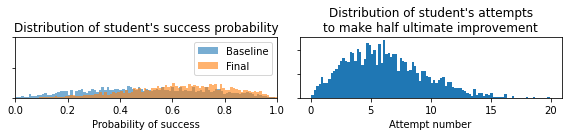

'uniform' (2000 students)


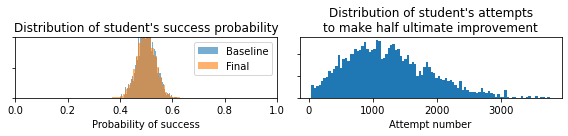

'initial' (2000 students)


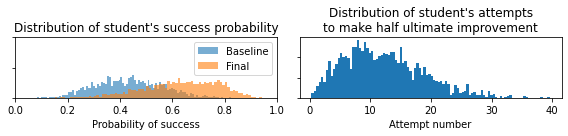

'second' (2000 students)


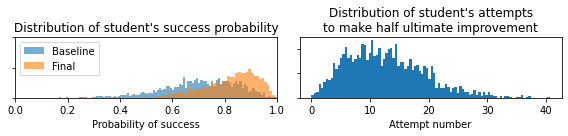

,baseline_alpha,baseline_beta,fall_in_failure_rate,half_time_mean,baseline_success_p,baseline_success_p_sd,final_success_p,final_success_p_sd,attempts_to_half_improvement,attempts_to_half_improvement_sd,key,sc,sac
variable,2,2,0.50,5,0.505710,0.227632,0.628682,0.187057,6.228314,3.253995,0.51_0.23_0.63_0.19_6.23_3.25,"{'bsp': [0.23660030472160726, 0.17221277066032...","[[0.23660030472160726, 0.24805480643556546, 0...."
uniform,100,100,0.00,1000,0.499648,0.035395,0.499648,0.035395,1247.969468,651.165695,0.50_0.04_0.50_0.04_1247.97_651.17,"{'bsp': [0.5025093224513555, 0.509828384076388...","[[0.5025093224513555, 0.5025093224513555, 0.50..."
initial,6,8,0.70,10,0.432448,0.126512,0.633963,0.140279,12.265731,6.582502,0.43_0.13_0.63_0.14_12.27_6.58,"{'bsp': [0.4567990482227037, 0.603429920331740...","[[0.4567990482227037, 0.4651407014487091, 0.47..."
second,7,3,0.75,10,0.704120,0.141041,0.814888,0.112395,12.694737,6.650412,0.70_0.14_0.81_0.11_12.69_6.65,"{'bsp': [0.7074412007057088, 0.691650055363140...","[[0.7074412007057088, 0.7083225443080691, 0.70..."


In [5]:
"""
Create and cache a set of student curves
"""
def make_student_sets(n=100, chattiness=1):
    metas = {
        "variable": {
            "baseline_alpha": 2,
            "baseline_beta": 2,
            "fall_in_failure_rate": 0.5, # how much do they improve (or does their failure rate drop)
            "half_time_mean": 5, # how quickly to students learn?
        },
        "uniform": {
            "baseline_alpha": 100,
            "baseline_beta": 100,
            "fall_in_failure_rate": 0, # how much do they improve (or does their failure rate drop)
            "half_time_mean": 1000, # how quickly to students learn?
        },
        "initial": {
            "baseline_alpha": 6,
            "baseline_beta": 8,
            "fall_in_failure_rate": .7, # how much do they improve (or does their failure rate drop)
            "half_time_mean": 10, # how quickly to students learn?
        },
        "second": {
            "baseline_alpha": 7,
            "baseline_beta": 3,
            "fall_in_failure_rate": .75, # how much do they improve (or does their failure rate drop)
            "half_time_mean": 10, # how quickly to students learn?
        }
    }
    student_sets = {}
    for name, meta in metas.items():
        print(f"Making {name} {n}")
        sc, sac = create_mock_students(
            baseline_alpha = meta['baseline_alpha'], 
            baseline_beta = meta['baseline_beta'],
            fall_in_failure_rate = meta['fall_in_failure_rate'], # how much do they improve (or does their failure rate drop)
            half_time_mean = meta['half_time_mean'], # how quickly to students learn?
            chattiness=chattiness, n = n)   
        final_meta = describe_student_curves(sc, meta)
        student_sets[name] = {**final_meta, "sc":sc,"sac":sac}
    return student_sets


def load_student_sets(testing=True, student_sets_file_prefix=False, overwrite=False):
    if testing:
        student_sets = pd.DataFrame.from_dict(make_student_sets(chattiness = 10, n=2000), orient='index')
    else:
        pickle_file = f"{student_sets_file_prefix}.pickle"
        if os.path.isfile(pickle_file) and not overwrite:
            with open(pickle_file, 'rb') as f:
                student_sets = pickle.load(f)
            pp(8, f"loaded {pickle_file}")
        else:
            pp(8, "generating")
            student_sets = pd.DataFrame.from_dict(make_student_sets(n=2000), orient='index')
            with open(pickle_file, 'wb') as f:
                pickle.dump(student_sets, f)
            pp(8, f"saved {pickle_file}")
    return student_sets

def plot_student_curves(student_sets):
    for set_name, meta in student_sets.iterrows():
        print(f"'{set_name}' ({len(meta['sc']['bsp'])} students)")
        plot_student_curve(meta['sc'])

student_sets_file_prefix = 'student_sets'
student_sets = load_student_sets(student_sets_file_prefix=student_sets_file_prefix, testing=False)
plot_student_curves(student_sets)
student_sets

In [6]:
def generate_trial_data(subject_n, attempt_n, trials, groups, sac):
    attempt_data = []
    participant_data = []
    trial_data = []
    totals = {}
    attempts_per_group = trials*subject_n*attempt_n
    print(f"{attempts_per_group} total attempts per group")
    for trial in range(trials):
        pp(7,f"=======\ntrial {trial}")
        for group, success_relative_increase in groups.items():
            pp(6, f"group: {group}")
            students = sac[np.random.choice(len(sac), subject_n, replace=True), :attempt_n]
            pp(5,students)
            result = succeeded(students,success_relative_increase)
            pp(6, f"result: {result}")
            pp(6, f"{group} success: {result.sum()}/{(result.size)} ({100*result.sum()/(result.size):3.1f}%)" )
            totals[group] = totals.get(group, 0) + result.sum()
            rec = {'trial': trial, 'group': group, "result": result.sum()}
            trial_data.append(rec)
            for p in range(subject_n):
                participant_results = result[p]
                rec["p"] = f"{group}{p}"
                prec = {**rec, "result": participant_results.sum()}
                pp(1,prec)
                participant_data.append(prec)
                for i in range(len(participant_results)):
                    irec = {**rec, "pint": p, "i": i, "result": 1 if participant_results[i] else 0}
                    pp(1,irec)
                    attempt_data.append(irec)

    pp(5, f"totals: {totals}")
    td = pd.DataFrame(trial_data)
    partd = pd.DataFrame(participant_data)
    ad = pd.DataFrame(attempt_data)
    return td, partd, ad, totals

In [7]:
def trial_plots(td, partd, ad, box=False):
    if box:
        whisker = 5
        ax = sns.boxplot(x="group", y="result", data=td, whis=[whisker, 100-whisker])
        title_msg =  " (Whiskers at {whisker}% and {100-whisker}%)"
    else:
        title_msg =  ""
    #ax = sns.swarmplot(x="group", y="result", data=td)
    ax = sns.violinplot(x="group", y="result", data=td)
    ax.set_ylabel('Successes (count)')
    ax.set_xlabel('Group')
    plt.title(f"Successful attempts in each arm of {ad.trial.max()+1} trials of {int(len(partd)/len(td))} students, each having {int(len(ad)/len(partd))} attempts.{title_msg}")
    plt.show()
    pd.crosstab(ad.result, ad.i).plot(kind='bar')
    plt.title("Success per iteration")
    plt.show()
    ad.groupby(['group', 'i']).result.sum().plot(stacked=True,kind='bar')
    plt.title("Success per iteration")
    plt.show()
    
def test_trial_generation(sac, groups, subject_n = 5, attempt_n = 5, trials = 1000):
    global verbosity
    verbosity = 10 if trials < 3 else 6 if trials < 10 else 2  # range of 0-10
    print(f"verbosity: {verbosity}")
    print(f"{trials} trials sampling {subject_n} for each of {len(groups)} groups out of {sac.shape[0]} students, each having {attempt_n} attempts")
    td, partd, ad, totals = generate_trial_data(subject_n, attempt_n, trials, groups, sac)

    def sumarise_trial(totals, attempts_per_group):
        results_percents = {}
        for group, result in totals.items():
            print(group, result)
            results_percents[group] = 100*result/attempts_per_group
        print(results_percents)
    sumarise_trial(totals, attempts_per_group=subject_n*attempt_n*trials)

    return td, partd, ad

# groups = {"control": 0, "interventionA":0.1, "interventionB":0.2, "interventionC":0.6, "nodif": 0}
#td, partd, ad = test_trial_generation(sac, groups)

In [16]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols, gee, mixedlm
#from statsmodels.formula.api import gee
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

"""
see: https://www.statsmodels.org/dev/_modules/statsmodels/genmod/cov_struct.html#CovStruct 
"""
def fit_models(ad, trials_to_test, tests):
    outcomes = {}
    for trial in trials_to_test:
        if not trial % 100:
            print(">",end='')
        pp(5, f"#### trial: {trial} #####")
        itd = ad.query(f"trial == {trial}") # individual trial data
        c = itd[['group','result']].groupby("group").sum().reset_index().set_index("group") # total counts in each groups
        res = False # reset to prevent accidental carryover
        for model in tests:
            pp(5, f"#### {model}")
            if model == 'ols':
                res = ols('result ~ C(group)+i', data=itd).fit()
            elif model == 'geeB':
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Exchangeable()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            elif model == 'geeBI':
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Independence()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            elif model == 'geeBIs': # drop the "i" variable (which tracks attempt number)
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Independence()
                mod = gee("result ~ C(group)", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            elif model == 'gee':
                fam = sm.families.Poisson()
                ind = sm.cov_struct.Exchangeable()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            elif model == 'bbm':
                #fixme  - see:
                # https://www.statsmodels.org/stable/generated/statsmodels.genmod.bayes_mixed_glm.PoissonBayesMixedGLM.html#statsmodels.genmod.bayes_mixed_glm.PoissonBayesMixedGLM
                mod = BinomialBayesMixedGLM("result ~ C(group)+i", "p", itd)
                res = mod.fit()
            elif model == 'mlm':
                mod = mixedlm("result ~ C(group)+i", itd, groups=itd["p"])
                res = mod.fit()
            elif model == 'mlms':
                mod = mixedlm("result ~ C(group)", itd, groups=itd["p"])
                res = mod.fit()

            else:
                raise Exception(f"bad model: {model}")
            pp(3, res.summary())
            p=res.pvalues[1]
            outcome = 'ns' if p > 0.05 else 'wrong' if c['result'][0] > c['result'][1] else 'sig' if p> 0.01 else 'vsig'
            pp(6, f"******************p = {p:0.6f} -{outcome}")
            key = f"{model}{outcome}"
            if outcomes.get(key, -1) == -1:
                outcomes.update({f"{model}wrong":0,f"{model}ns":0,f"{model}sig":0,f"{model}vsig":0,f"{model}p":[]})
            outcomes[key] += 1
            outcomes[f"{model}p"].append(p)

    return(outcomes)


In [9]:
def read_trials(trial_cache_dir):
    pp(10, f'reading {trial_cache_dir}')
    ad = pd.read_csv(f"{trial_cache_dir}/ad.csv.gzip", compression='gzip')
    partd = pd.read_csv(f"{trial_cache_dir}/partd.csv")
    td = pd.read_csv(f"{trial_cache_dir}/td.csv")
    return td, partd, ad
    pp(10, 'done')

def write_trials(td, partd, ad, trial_cache_dir, overwrite=False):
    Path(trial_cache_dir).mkdir(parents=True, exist_ok=not overwrite)
    pp(10, f'writing {trial_cache_dir}')
    ad.to_csv(f"{trial_cache_dir}/ad.csv.gzip", compression='gzip')
    partd.to_csv(f"{trial_cache_dir}/partd.csv")
    td.to_csv(f"{trial_cache_dir}/td.csv")
    pp(10, 'done')

def get_trials(student_sets, trialn = 100, subject_n = 200, attempt_n = 20):
    trials = {}
    for student_set_name, student_meta in student_sets.iterrows():
        print(f"'{student_set_name}' ({len(student_meta['sc']['bsp'])} students)")
        trial_cache_dir = f"trial_cache/{student_set_name}_{trialn}_{subject_n}_{attempt_n}"
        if os.path.isdir(trial_cache_dir):
            td, partd, ad = read_trials(trial_cache_dir)
        else:
            print(f"generating fresh trial data as `{trial_cache_dir}` does not exist")
            print(f"using '{student_set_name}' ({len(student_meta['sc']['bsp'])} students)")
            groups = {"control": 0, "interventionA":0.1, "interventionB":0.2,
                      "interventionBa":0.4, "interventionBb":0.5,
                      "interventionC":0.6, "interventionD": 0.8, "nodif": 0}
            td, partd, ad = test_trial_generation(student_meta['sac'], groups, subject_n = subject_n, attempt_n = attempt_n, trials = trialn)
            write_trials(td, partd, ad, trial_cache_dir, overwrite=False)
        trials[student_set_name] = {"td":td,"partd":partd,"ad":ad}
    return trials

## add some more arms to the trials and save in new directory
"""
if addintervention:
    new_trial_cache_dir = f"{trial_cache_dir}e"
    groups = {"interventionBa":0.4, "interventionBb":0.5}
    pop_type = 'tight'
"""                 
def extend_trial(td, partd, ad, groups, new_trial_cache_dir, subject_n = 200, attempt_n = 20):
    print("generating extra trial data")
    trial_cache_dir = f"trial_cache_{pop_type}{trialn}"
    tde, partde, ade = test_trial_generation(sac, groups, subject_n = subject_n, attempt_n = attempt_n, trials = trialn)
    td = td.append(tde)
    ad = ad.append(ade)
    partd = partd.append(partd)
    write_trials(td, partd, ad, new_trial_cache_dir)

In [10]:
if testing:
    trials = get_trials(student_sets, trialn = 10, subject_n = 10, attempt_n = 5)     
else:
    trials = get_trials(student_sets, trialn = 100, subject_n = 400, attempt_n = 20)     

'variable' (2000 students)
reading trial_cache/variable_100_400_20
'uniform' (2000 students)
reading trial_cache/uniform_100_400_20
'initial' (2000 students)
reading trial_cache/initial_100_400_20
'second' (2000 students)
reading trial_cache/second_100_400_20


Summary of trials done on different student populations
variable


result                
                    mean     sum   count
group                                   
control         0.581035  464828  800000
interventionA   0.617844  494275  800000
interventionB   0.648879  519103  800000
interventionBa  0.700619  560495  800000
interventionBb  0.720291  576233  800000
interventionC   0.737541  590033  800000
interventionD   0.767552  614042  800000
nodif           0.581975  465580  800000

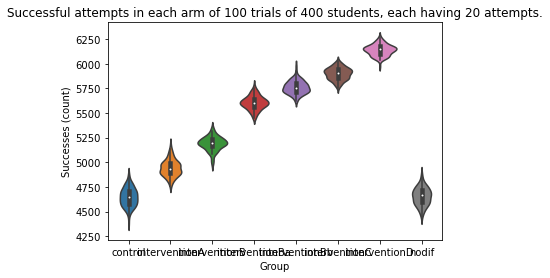

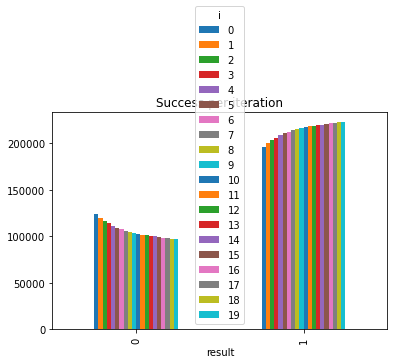

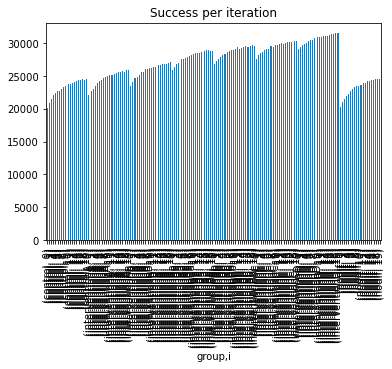

uniform


result                
                    mean     sum   count
group                                   
control         0.499640  399712  800000
interventionA   0.545269  436215  800000
interventionB   0.583449  466759  800000
interventionBa  0.642374  513899  800000
interventionBb  0.666725  533380  800000
interventionC   0.686899  549519  800000
interventionD   0.722809  578247  800000
nodif           0.499759  399807  800000

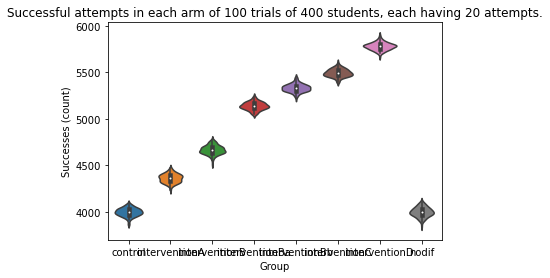

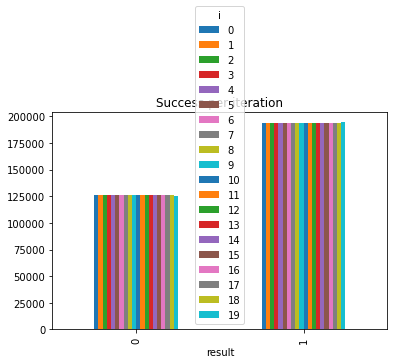

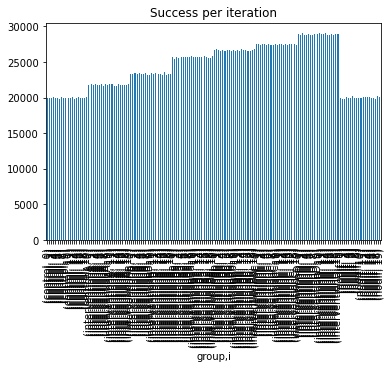

initial


result                
                    mean     sum   count
group                                   
control         0.519930  415944  800000
interventionA   0.564600  451680  800000
interventionB   0.599250  479400  800000
interventionBa  0.657365  525892  800000
interventionBb  0.679211  543369  800000
interventionC   0.701233  560986  800000
interventionD   0.733181  586545  800000
nodif           0.520654  416523  800000

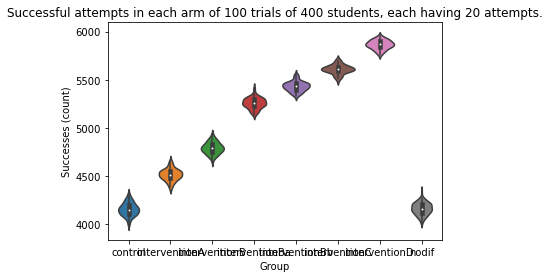

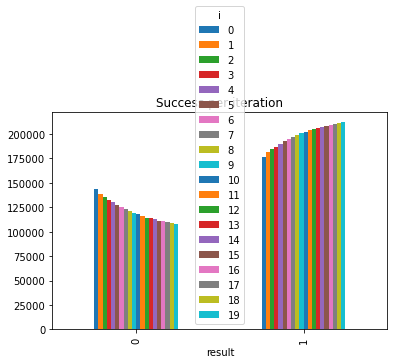

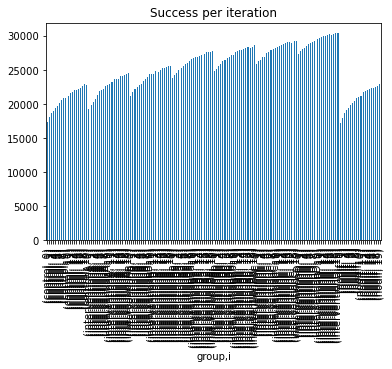

second


result                
                    mean     sum   count
group                                   
control         0.752524  602019  800000
interventionA   0.773672  618938  800000
interventionB   0.792865  634292  800000
interventionBa  0.822396  657917  800000
interventionBb  0.833589  666871  800000
interventionC   0.844101  675281  800000
interventionD   0.862635  690108  800000
nodif           0.750326  600261  800000

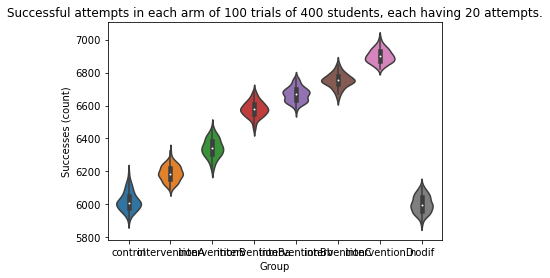

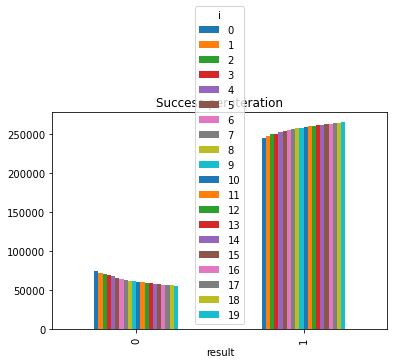

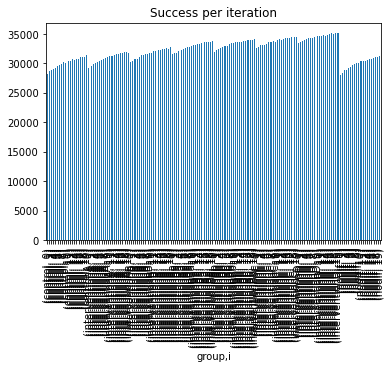

In [11]:
print("Summary of trials done on different student populations")
for student_set, trial in trials.items():
    ad = trial['ad']
    group_totals = ad[['group','result']].groupby('group').agg(['mean', 'sum', 'count'])
    print(student_set)
    display(group_totals)
    trial_plots(trial['td'], trial['partd'], trial['ad'])

In [12]:
# This is essentiall a wrapper around fit_models() to enable caching
def run_sym(student_set, attempt_data, pairs, tests, trials_to_test, spg, aps,
    run_key="A",cache_path="cache/"):
    print('.', end='')
    global verbosity
    verbosity = 6 if trials_to_test < 5 else 4
    sym_results = []
    for comparision, pair in pairs.items():
        for students_per_group in spg: #[5, 10]:
            for attempts_per_student in aps: #[5,10]:
                # attempt to read from a cache file
                key = f"{run_key}.{trials_to_test}{comparision}.{students_per_group}.{attempts_per_student}"
                file = f"{cache_path}/{student_set}/{key}.json"
                if os.path.isfile(file):
                    with open(file) as f:
                        rec = json.load(f)
                    pp(8, f"loaded {file}")
                else:
                    query = f"group == {pair} and pint < {students_per_group} and i < {attempts_per_student}"
                    trial_data = attempt_data.query(query)
                    pp(10, f"`{query}` ({len(trial_data)} total attempts)")
                    run_results = fit_models(ad=trial_data, trials_to_test=range(trials_to_test), tests=tests)
                    pp(10, f"run_results: {run_results}")
                    rec = {"student_set": student_set,
                         "comparision":comparision, 
                         "students_per_group": students_per_group, 
                         "attempts_per_student": attempts_per_student,
                         "groupA": pair[0], "groupB": pair[1], 
                         "total_attempts": len(trial_data),
                         "trials": trials_to_test,
                         **run_results,
                         'query': query, 'time':time.time()*1000,
                         'key': key}
                    Path(os.path.dirname(file)).mkdir(parents=True, exist_ok=True) # make the cache dir
                    with open(file, 'w') as f:
                        pp(8, f"saving {file}")
                        json.dump(rec, f)
                sym_results.append(rec)
    return pd.DataFrame(sym_results)

In [13]:
# Test running code
# Edit the code below to loop over different simulations
def run_test(testing = True, phase=0):
    pairs = {'none': ['control','nodif'],
                 'vsmall': ['control','interventionA'],
                 'small': ['control','interventionB'],
                 'mod': ['control','interventionBa'],
                 'mod1': ['control','interventionBb'],
                 'big': ['control', 'interventionC'],
                 'huge': ['control', 'interventionD'],
                 'upper': [ 'interventionC', 'interventionD']
                }
    pairs = {'none': ['control','nodif'],
                 'small': ['control','interventionB'],
                 'mod': ['control','interventionBa'],
                 'mod1': ['control','interventionBb'],
                 'big': ['control', 'interventionC'],
                }

    tests = ['mlm', 'mlms', 'geeBIs','geeBI', 'gee'] #, 'bbm']
    if testing:
        students_per_group = [10]
        attempts_per_student = [5]
        trials_to_test = 2
        cache = "cache_test_t/"
    else:
        students_per_group = [75] if phase == 0 else [30, 75, 100] if phase == 1 else [20, 30, 50, 75, 100, 200, 400]
        attempts_per_student = [10] if phase < 2 else [10,20]
        trials_to_test = trials['uniform']['ad'].trial.max()+1
        cache="cache2/"

    print(f"testing {trials_to_test} trials")
    syms = [] # temporyary value replaced with a dataframe
    for student_set, trial in trials.items():
        ad = trial['ad']
        sym = run_sym(
            student_set = student_set,
            attempt_data = ad,
            pairs = pairs,
            run_key="e", tests = tests,
            trials_to_test = trials_to_test,
            spg = students_per_group,
            aps = attempts_per_student,
            #run_key="c",   tests = ['geeB','geeBI','geeBIs']
            cache_path=cache)
        # accumulate all the results into a single df
        syms = syms.append(sym) if len(syms) else sym
    return syms

In [ ]:
#test3 = run_test(testing=testing)
#test4 = run_test(testing=False)
for phase in range(1 if testing else 3): # 
    print(f"phase {phase}+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    sym_run = run_test(testing=testing, phase=phase)
    outfile = f'test10a.{phase}.csv'
    sym_run.to_csv(outfile)
    print(f"saving {outfile}")
print('done')   

phase 0+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
testing 100 trials
.`group == ['control', 'nodif'] and pint < 75 and i < 10` (150000 total attempts)
>

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

run_results: {'mlmwrong': 4, 'mlmns': 93, 'mlmsig': 2, 'mlmvsig': 1, 'mlmp': [0.48022235565732896, 0.28351231747949246, 0.9449264217349475, 0.38271088288436306, 0.7745722860967765, 0.19018689969451452, 0.17528070850110022, 0.6584272863849081, 0.6887840438817057, 0.2585679806646849, 0.8986030441125857, 0.20923934886949436, 0.7841281436593585, 0.857599039240498, 0.42228378403796507, 0.32738824922568954, 0.9217207725176895, 0.5977088828295983, 0.41891303603073327, 0.1997515320863945, 0.7313721376124351, 0.9744630979278294, 0.9727487958750812, 0.35881174721296505, 0.5570806752328752, 0.5742732035038732, 0.667475628224099, 0.31493885090828266, 0.721916402816328, 0.4679353298394996, 0.6254210214417495, 0.5205631703826139, 0.22296477312052465, 0.13699252423656486, 0.5420631953935506, 0.535932236481666, 0.2816101155442472, 0.22773638632957804, 0.31683053893985513, 0.8225066181681059, 0.2777778276998506, 0.25545593051738247, 0.06583698407421103, 0.4127127340828809, 0.4378468240891553, 0.0509481

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

run_results: {'mlmwrong': 0, 'mlmns': 57, 'mlmsig': 25, 'mlmvsig': 18, 'mlmp': [0.1623121359312455, 0.04317735004793517, 0.31034254211625234, 0.32270228419991775, 0.04158565369581795, 0.2664999938485536, 0.12121101452839739, 0.06491417806810701, 0.0026183035202528154, 0.02373213017269085, 0.12510833629899157, 0.2560364244336374, 0.006072557036975215, 0.4010620191672194, 0.3711555567073471, 0.17652848104651886, 0.18194779321379861, 5.4335482664921324e-05, 0.023401591834410995, 0.9749483245813474, 0.6731307106934996, 0.1492715116273991, 0.04850029639731396, 0.31876211189413517, 0.13797059241734283, 0.07270768739862099, 0.11780450494537519, 0.7367448150449489, 0.036601132802663305, 0.3688015914547794, 0.061522445643649885, 0.007537991219306966, 0.01565054551012745, 0.00472587652066425, 0.18156964518885965, 0.3228398353011399, 0.03902434313560482, 0.04906345200354533, 0.7402474405379467, 0.05967146818546444, 0.0758782397220301, 0.21820733763965705, 0.04869129235576885, 1.8469783863404077e-

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

run_results: {'mlmwrong': 0, 'mlmns': 11, 'mlmsig': 14, 'mlmvsig': 75, 'mlmp': [0.013107163593997665, 0.005011690608449477, 0.0009950012308270453, 0.02852075287412851, 0.07413578892526457, 0.024588271026481232, 0.04718315591701994, 0.024196084013656857, 0.014992065188191664, 0.003220409474508792, 0.004636550581558056, 0.004859193073698546, 0.0009280108241695279, 0.001707593681750574, 0.0005933867558938181, 0.014277679605679862, 0.00048707337223271647, 7.619046375347678e-06, 0.0007616104005704168, 0.029892858210291907, 0.28028382964937826, 0.0020038456488717903, 0.00012394757066619113, 0.0049028228971939114, 0.016081198698739595, 1.1182797161585231e-07, 3.520892216152613e-05, 0.09048930008520996, 0.000726043814718269, 0.016708752821720615, 0.00034226476777617136, 0.04203384497994353, 0.0070294054300060246, 5.058882367295053e-06, 0.0003058579334135305, 0.001622595870093176, 0.008418249844887543, 5.343511908821075e-05, 0.008922525503024397, 1.162110320243102e-06, 0.0009778128749883394, 0.

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

run_results: {'mlmwrong': 0, 'mlmns': 3, 'mlmsig': 7, 'mlmvsig': 90, 'mlmp': [0.0020803348477717986, 0.010087014501506062, 0.008105917066149987, 0.0003726686562946415, 0.007953796864401572, 0.01274792869462353, 0.0742997102552427, 2.834366602262428e-07, 6.534074223536496e-08, 0.0006709345927222156, 0.0008105481808343247, 0.004060095999239131, 0.00023389012721678084, 4.613106431238871e-05, 0.0001294348189087665, 0.0027849174509027032, 0.014943259439282958, 7.444351563270667e-08, 0.0003111712997766188, 0.0056695307161221935, 0.01001807091319111, 0.001986250495140622, 0.0006088625350116966, 0.011113581010007145, 0.00027393134642084697, 0.00017265256124385678, 0.0004709062910119134, 0.15439373554330357, 4.123080916607875e-06, 0.0032708193116110064, 1.188422255328117e-05, 1.615388900810773e-05, 0.0007657739541183208, 2.2156412422911497e-06, 2.6592611406515306e-05, 0.003532481418008109, 3.634951331968459e-05, 0.0011637478317509593, 0.0008986773370941627, 2.3234380585734238e-06, 1.89896137196

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi

run_results: {'mlmwrong': 0, 'mlmns': 0, 'mlmsig': 3, 'mlmvsig': 97, 'mlmp': [0.0007681460682690781, 1.6978104333693322e-07, 8.619798169545453e-06, 0.003174497772072961, 0.00038664084832396505, 1.0229324795478253e-06, 0.004108176191353515, 0.001188555518449692, 5.053258000755408e-06, 3.385573798229316e-05, 1.156304774771174e-06, 0.000787276497978816, 1.328676467352426e-06, 0.00013382730425220364, 1.2759536135841847e-05, 1.0729894082747382e-06, 1.2041256399157267e-07, 1.2836480473181916e-07, 3.894655146740055e-07, 0.0014925303294520346, 0.00039778478581285336, 3.9804395142070215e-05, 8.18793803506823e-05, 0.0008271135510783403, 0.0005591436560565522, 4.2717661621393283e-07, 0.0001691061348290215, 0.0013948225389345697, 1.8625723427175794e-06, 0.00044775031103382274, 2.03131673062974e-05, 1.5933420929236014e-06, 3.279167156728362e-06, 1.8976176887894837e-12, 2.2365606817489926e-07, 0.005697108259638035, 4.078437556835328e-06, 4.250779424969877e-05, 2.884225094239676e-05, 2.88430239148022

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

run_results: {'mlmwrong': 2, 'mlmns': 95, 'mlmsig': 3, 'mlmvsig': 0, 'mlmp': [0.2588379703477238, 0.44550593707742525, 0.7267344437052631, 0.7965565974243286, 0.3176531487571941, 0.4068884840442645, 0.1836025403229785, 0.9193188116093928, 0.23557364611640785, 0.9269353829819887, 0.6628298302734732, 0.728995839347504, 0.17958929147206815, 0.6544062546461135, 0.6053964476726564, 0.6099010118437156, 0.40889602092923205, 0.6423113940315488, 0.7679644699508805, 0.31145109823126715, 0.5093628143965827, 0.8367511706698441, 0.961019954059219, 0.9181235228210712, 0.3085859283149234, 0.08777981608447184, 0.7568193415793265, 0.24453452314891222, 0.4884861554875116, 0.4704389007674137, 0.5019356444348138, 0.7187195541915423, 0.7706785436273189, 0.5109414835972153, 0.03854140757517646, 0.6797837350196947, 0.44261915933631435, 0.3021075437732784, 0.41676283513091184, 0.12753677128657767, 0.6071486082143078, 0.8086633823485894, 0.6797529360727574, 0.1577126854507287, 0.9179542950577178, 0.56572556507

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.wa

run_results: {'mlmwrong': 0, 'mlmns': 10, 'mlmsig': 21, 'mlmvsig': 69, 'mlmp': [0.0006162226246699211, 0.019756826700922617, 0.0002773725188951501, 9.617279211608224e-05, 0.0003233244896305277, 0.0017712394964737174, 0.0003537936258324892, 0.008165127731367884, 1.9799798800530917e-05, 0.01773041992706189, 0.01122991103031855, 3.170184558455216e-05, 0.3274720373844391, 0.0047717529173658645, 1.2210102673317588e-08, 0.0008252156437591478, 0.0008680559771489062, 0.002724684212576539, 6.226152712191125e-07, 0.029519863248846645, 1.1742118934142285e-06, 0.0009487444221026259, 0.003035497735054299, 0.0026352326647721214, 0.0003278003650648155, 0.03357282710579677, 0.003779546437639887, 2.1542171630697025e-06, 0.013433360313266602, 0.00014778309048141735, 0.002217434465284974, 5.915813366649061e-05, 0.15330648200669691, 0.013780554389541105, 6.458368696796821e-06, 0.0007148606796418687, 2.5322610620108837e-05, 5.833606757077178e-09, 0.1198018300844738, 0.037845716182663254, 0.0046109942820705

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.wa

run_results: {'mlmwrong': 0, 'mlmns': 0, 'mlmsig': 1, 'mlmvsig': 99, 'mlmp': [2.9160602887269497e-07, 5.958606440884179e-10, 7.318441807370251e-09, 5.493724950237745e-12, 6.398282643456808e-14, 3.095108503953883e-05, 1.3252712292342404e-05, 2.2248062290276016e-14, 1.4757683028087843e-08, 1.453118723776383e-08, 5.925991695645218e-10, 3.208179420527895e-10, 1.43348657467711e-06, 5.108772251108174e-06, 6.760401558736892e-12, 1.1735729104854523e-10, 4.929518486244445e-08, 1.2143581099774656e-06, 2.995061024129922e-07, 5.382569962346675e-05, 2.511007140158796e-10, 7.011185595082881e-09, 8.627096362750577e-12, 5.5393422379031566e-11, 1.265748590183577e-06, 1.036801906905519e-08, 1.9140876215407107e-12, 1.1813104206688777e-10, 3.301870047031681e-07, 5.795134538558991e-11, 1.0489818830459563e-09, 1.0937848403522176e-10, 0.014849147723037854, 1.1775482076520507e-08, 2.656762707922266e-10, 7.232227828967907e-09, 3.213685271166578e-15, 8.8394190309518e-09, 9.656397352991649e-08, 5.610695673962573

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-pack

run_results: {'mlmwrong': 0, 'mlmns': 0, 'mlmsig': 0, 'mlmvsig': 100, 'mlmp': [8.664463342609122e-14, 7.935969603266834e-14, 3.8995598627688295e-10, 1.8697006384004836e-11, 5.992675913323136e-13, 1.691482309186885e-10, 0.00035379362572526943, 9.495949646949657e-11, 2.5687030470797272e-14, 1.4711277582721466e-07, 1.6567029849831426e-14, 7.507513457210798e-12, 3.001642835764137e-08, 5.148765740232914e-09, 9.835187959068089e-16, 1.5215715454350453e-11, 5.1843576571201235e-08, 4.9910989643685813e-11, 8.53169675502052e-12, 3.6369332130614004e-13, 2.894333096181061e-16, 1.4448574312666277e-07, 2.778512524668108e-14, 2.2386827965461208e-14, 2.3334857244984036e-06, 1.061679328414255e-08, 1.3636437867814273e-11, 1.9222443897978653e-13, 2.1554054255979752e-11, 2.5353814257922913e-12, 2.535751421314686e-13, 4.325320212618235e-12, 4.950978663034406e-09, 4.317926680858152e-08, 3.755819375025863e-13, 6.3095932374755485e-09, 4.4266057369334726e-11, 1.1710918105557345e-15, 6.278022586553521e-09, 6.697

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

run_results: {'mlmwrong': 0, 'mlmns': 0, 'mlmsig': 0, 'mlmvsig': 100, 'mlmp': [3.165637057004071e-17, 7.20804703971097e-20, 5.067780319609798e-14, 8.874909355279204e-17, 7.680963602214945e-17, 2.2024303263310623e-07, 8.046220699909081e-10, 2.158499974832329e-15, 3.991429798096722e-17, 2.4755611256394153e-12, 2.9016601846553685e-14, 4.442935925460844e-17, 3.2838102842259678e-09, 7.024376197818227e-14, 4.7828804819578074e-17, 4.621024726203316e-14, 2.3243092427492731e-10, 2.3563889122834637e-11, 1.6317229505247504e-15, 3.0392030863008066e-10, 2.5230520777037096e-13, 1.8883274723582012e-13, 5.219237629462201e-17, 6.567283818151808e-16, 4.627078853039615e-13, 1.6582453957827242e-10, 4.371435150729461e-14, 1.1005133969426226e-15, 1.541291329473151e-14, 7.321851924541782e-16, 1.4890212541000834e-13, 4.748305081748348e-14, 2.7268597717477863e-08, 1.1779286146821526e-08, 2.8683807850574504e-20, 1.1700821365201732e-14, 7.999224791963943e-15, 1.0391248476915014e-15, 4.591693366016954e-12, 4.3006

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

run_results: {'mlmwrong': 3, 'mlmns': 92, 'mlmsig': 4, 'mlmvsig': 1, 'mlmp': [0.13059672077387668, 0.17862606433781547, 0.8364298613618022, 0.2856772107087858, 0.9771065235318396, 0.5490664753789354, 0.49022742324830815, 0.6122512219679173, 0.9370787037614844, 0.874398474505085, 0.14831211196312305, 0.2553995842668644, 0.10849062359078397, 0.7296796157923446, 0.7160707632863357, 0.6176355187721092, 0.4267023547306955, 0.23432101619437617, 0.3917365418837676, 0.5565687116955687, 0.5233077338312065, 0.7269386748736577, 0.5902286081503999, 0.22377480943737837, 0.4759087895341818, 0.6037293594792144, 0.9682171973301886, 0.11015877790418613, 0.3411152021465782, 0.769794868854802, 0.9672321015782923, 0.017101939850877882, 0.4891816188851561, 0.2167552570401321, 0.7241469811097501, 0.2843710959642034, 0.838593332495852, 0.023707684083713067, 0.04026425239008326, 0.2234690540690596, 0.8588068348146944, 0.7363726060654245, 0.5749861026209035, 0.43175667638694515, 0.614765889076923, 0.2188472428

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

run_results: {'mlmwrong': 0, 'mlmns': 22, 'mlmsig': 19, 'mlmvsig': 59, 'mlmp': [5.128092057605446e-05, 0.0004013839844212435, 0.00017786813497760066, 0.017251408704553255, 0.16414221330062817, 8.801355487569838e-05, 0.1098044667403761, 0.012002358201521714, 0.4447100720120942, 0.008215622799037696, 0.00501634899458977, 0.0001382896552754621, 0.0534854824947664, 0.03413809771172214, 0.0038154593721972103, 3.6592609435041834e-06, 0.08736444183939208, 0.003624453812908089, 0.07014189706082793, 0.0486198767782819, 0.17481976787523457, 0.001789526535956989, 0.0021669192939730883, 0.37840018060546576, 0.02266021885498264, 0.0012994364916355194, 0.01301846731065893, 0.006583376124122505, 2.2652544138068716e-05, 0.14058918411561877, 0.03858075841153961, 0.5368230260658851, 0.009545823708407104, 0.001224022358525036, 0.251912604564438, 0.0020986447702170292, 0.15772601029199895, 5.9136714064568934e-06, 7.494002110288932e-06, 0.001255792312131111, 3.508165449389996e-07, 0.267724903108724, 0.0003

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

run_results: {'mlmwrong': 0, 'mlmns': 0, 'mlmsig': 2, 'mlmvsig': 98, 'mlmp': [1.2914733187230263e-07, 6.589100675270757e-07, 4.3866137163175817e-10, 0.0011777066868774331, 0.013052929531822818, 1.2034332487502547e-06, 1.334856518037555e-06, 6.228716694614316e-08, 2.82695022893873e-06, 0.00018305912000951557, 1.594702365950973e-08, 9.815686779275725e-10, 0.0001741245257216916, 3.991978198984777e-07, 5.266670957314652e-05, 5.769371049890741e-07, 1.7235859760260937e-07, 4.5430635972323344e-07, 0.0001087500468573664, 0.007836430977403299, 0.00028386228603210703, 3.826244308189451e-06, 1.8927730086730096e-06, 0.00292723970794196, 0.0012196413604881379, 0.00021455257530648882, 5.795840317228406e-08, 3.488650676198244e-08, 4.268993883262822e-08, 0.002036686371192975, 2.525806806185818e-06, 8.759441978735707e-05, 2.8068700286988133e-07, 3.751697752902912e-07, 2.8979877159582484e-06, 5.882153022215405e-05, 2.4955067080658574e-05, 3.971198664102141e-10, 7.891186066571462e-06, 9.114469954819897e-

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

run_results: {'mlmwrong': 0, 'mlmns': 0, 'mlmsig': 0, 'mlmvsig': 100, 'mlmp': [1.6362790430211905e-10, 2.7907580750794375e-15, 6.571086547287473e-11, 4.923647644454573e-05, 5.721636886378483e-06, 7.174604236494675e-17, 9.854467154448161e-12, 1.8338323959740392e-06, 9.42443147760749e-10, 1.4107359935664673e-07, 3.2417171059522453e-18, 8.112587036564403e-09, 7.401572710607688e-07, 1.0173107697130643e-07, 5.669757293841474e-10, 1.1661528581926338e-11, 1.7279836473771109e-13, 9.054708818432337e-11, 3.1370176483203816e-06, 0.00024335791872911208, 4.599743496677097e-07, 4.016216105894629e-10, 7.1813012636972755e-09, 1.3833267029807772e-07, 8.001369208973062e-08, 3.6522686765297796e-08, 4.102135638534823e-10, 1.4140933002716228e-07, 1.1015414670094815e-08, 0.0009266678356003394, 1.8456493969404758e-07, 4.14802448227287e-05, 0.00013821818476848804, 5.966633019629184e-10, 9.357063077977986e-08, 1.1864145231174395e-06, 6.001270782106619e-07, 1.836922506551385e-13, 2.6619725484233163e-12, 6.13689

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

run_results: {'mlmwrong': 0, 'mlmns': 0, 'mlmsig': 0, 'mlmvsig': 100, 'mlmp': [7.920440790668856e-10, 8.477292916972329e-13, 2.6544794245762056e-14, 1.5572077034599709e-06, 1.1832749451901166e-06, 6.394854978406119e-16, 1.435212503729085e-12, 7.130671360305039e-12, 1.3341970716612535e-10, 2.1612332405120942e-09, 2.3356924512168805e-13, 2.954283749059767e-20, 3.3553800453265954e-07, 2.309004889395369e-08, 7.194885074040854e-10, 1.567541987226333e-11, 6.300118128595386e-12, 1.1582604404984586e-13, 6.805542321318101e-10, 1.778967439903665e-11, 7.076919004339494e-10, 1.6295227900372997e-14, 1.1936897131130777e-09, 2.2965357175494034e-09, 8.65461402935022e-10, 1.601071091701053e-05, 1.6866876360180463e-09, 6.904774408688269e-13, 4.833920983621943e-13, 4.479779204347436e-08, 5.789172067403054e-13, 1.9322654571092027e-05, 4.678108149149766e-12, 1.3337393572514604e-09, 5.333913465446226e-07, 1.4606816612543635e-09, 9.544432470726e-09, 5.434117583646924e-15, 1.6537768735455198e-14, 5.1358226856

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

run_results: {'mlmwrong': 2, 'mlmns': 96, 'mlmsig': 2, 'mlmvsig': 0, 'mlmp': [0.02205635424833779, 0.9642568881535823, 0.7423003823766585, 0.5609960090881592, 0.5378529765143796, 0.9622080386447374, 0.5477626102250395, 0.594230037303026, 0.2304817052590714, 0.8137462272441488, 0.20569468037183658, 0.11302754813993751, 0.2696776976441053, 0.2970456900297491, 0.806434946616694, 0.4522799290379814, 0.9467339516306233, 0.4829608906227131, 0.4847135364845774, 0.6189572908098436, 0.4287800183465037, 0.8401350604434945, 0.47213584716433654, 0.33383922209791084, 0.9615917220666019, 0.6167595808219095, 0.549017864106828, 0.8912831037807281, 0.8484511143147555, 0.1868222060123761, 0.8075338773134435, 0.5293066232423339, 0.5957877050481892, 0.03393305556926981, 0.4885513042352989, 0.05278665714320376, 0.46828623770266176, 0.4709955059482378, 0.45969748588933756, 0.948453564615569, 0.18205007540759832, 0.3477391510909209, 0.7161203982176578, 0.8216764450895773, 0.2276138838721663, 0.38570099469979

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

run_results: {'mlmwrong': 0, 'mlmns': 72, 'mlmsig': 18, 'mlmvsig': 10, 'mlmp': [0.5826985664111765, 0.3361927149961145, 0.004915091757267165, 0.06677096564660372, 0.204267280845303, 0.1670701267537723, 0.09290011997546788, 0.8709754913609176, 0.6144434676874513, 0.04390736294832641, 0.49328468587430363, 0.45149633882776463, 0.596892976686457, 0.45827645308913545, 0.04361689433686356, 0.0034678048378226516, 0.5588125552341483, 0.4370547448960901, 0.7709123333771509, 0.6920981252761789, 0.02313488984076869, 0.4992250368031489, 0.0161780694734569, 0.014935039350050071, 0.09875895997640545, 0.9999999999998356, 0.5809177271254788, 0.2549503430362672, 0.07884398567722278, 0.0038705375058706317, 0.5037747589598695, 0.1165081268073712, 0.7575441105228623, 0.31556106093351244, 0.20001133021082895, 0.9711242510196902, 0.32800505653494905, 0.003342173100460757, 0.45901023253141926, 0.04207413960345864, 0.10404560928511038, 0.005428388400157798, 0.08137982411275833, 0.25264077363551607, 0.00661140

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

run_results: {'mlmwrong': 0, 'mlmns': 31, 'mlmsig': 21, 'mlmvsig': 48, 'mlmp': [0.012273538363365323, 0.05743597899744441, 0.010300976585763098, 0.0012360841011540373, 0.001507619532069828, 0.005029657256711879, 0.013354488293091037, 0.059336101501177144, 0.4300767551950643, 0.04757688523541788, 0.005804736973403993, 0.06349899768093062, 0.0087924302906005, 0.009382138425866585, 0.17058410390729228, 0.01912332957516264, 0.22028717544603393, 0.6386088794709006, 0.032768735410200936, 0.07060992046891554, 4.21630389204741e-05, 0.08329607186114253, 0.009627243350184502, 0.00029685108991545637, 0.002859862330755817, 0.021187215856120458, 0.012493482038690431, 0.015968929516183512, 0.00015237410244140376, 0.0013468965707119072, 0.008627133855918836, 0.005767897906364451, 0.07453760546821513, 0.10031790042142011, 0.0019039580506447877, 0.25886074627033906, 0.008164779178381137, 0.0035394957019647027, 0.2745980114506944, 0.0007221662463905802, 0.0008057483827142477, 0.00015345694720474333, 0.0

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

run_results: {'mlmwrong': 0, 'mlmns': 18, 'mlmsig': 24, 'mlmvsig': 58, 'mlmp': [0.014066095987740852, 0.012055892481347872, 0.0018145121413387377, 0.011118859333206254, 0.004321182100851476, 0.0018065734799997083, 1.0339251911853928e-05, 0.04514470597724802, 0.062083368054511284, 0.03240673546017785, 0.01840412454447491, 0.01643273788645873, 0.00017123580643155906, 0.029563768911129443, 0.0013391690883028972, 4.663598582299576e-06, 0.08900457819569178, 0.027956360434166036, 0.00013947135737873146, 0.09173756289387108, 1.5158751863214477e-05, 0.0008621349301590205, 1.5680651755158766e-05, 0.0037062471629957824, 0.0821254225727059, 0.0012151426217860202, 7.22697660419589e-05, 0.00014081119655132252, 0.01428015580347182, 4.671295247158173e-09, 0.007784894507918137, 0.0004881733154990002, 0.043232122903500404, 4.50769772782017e-06, 0.00393800935193989, 0.07394064543747389, 0.016050154960315463, 0.00026768058034823617, 0.14665397786350687, 0.0007502918210224059, 0.00012859486839587487, 0.00

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

run_results: {'mlmwrong': 0, 'mlmns': 8, 'mlmsig': 10, 'mlmvsig': 82, 'mlmp': [0.000947536197828822, 0.0006188700028825816, 0.0004387802876660424, 6.1351657327363816e-06, 0.024179018246963262, 0.00028247746593966185, 0.00020830754901331338, 2.8174177343026344e-06, 0.013375513923089652, 9.107728677123294e-06, 0.0024318808581906713, 8.261450283792001e-06, 5.593175460325356e-07, 0.008904553243252412, 6.42746080496858e-06, 0.00011367023090309507, 0.02108887450008378, 0.23417431437381275, 4.056238161077545e-05, 0.011909204146682941, 1.2678117780072067e-05, 0.07051449527456072, 1.8871058019146117e-05, 1.706540583996179e-05, 5.500427147544327e-08, 0.003452013246580663, 0.003001409532325782, 0.0008977353255888571, 3.23190931455236e-06, 1.5922201754232472e-10, 0.0017483290658871532, 3.7414724613179455e-05, 0.0005266046197126279, 3.431127807944066e-06, 0.00011091071446019075, 0.041880687977242925, 0.00016910732564180358, 0.0009468119994173015, 0.004629436454082444, 3.9221836045388724e-05, 2.3835

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

run_results: {'mlmwrong': 3, 'mlmns': 95, 'mlmsig': 1, 'mlmvsig': 1, 'mlmp': [0.29000687436552197, 0.39254840574328675, 0.29648311759437695, 0.64040958601568, 0.4062080192684877, 0.4522159419466355, 0.961989843871758, 0.3472682770734047, 0.14119879731248156, 0.20924181925581264, 0.21569482303789467, 0.3679727804108005, 0.20081896027454837, 0.26956452571612166, 0.44895363392843246, 0.9153124214889123, 0.1482202091009502, 0.9589550277827535, 0.8737267489595891, 0.3639077769635267, 0.918939291107835, 0.4246562204525096, 0.6013053708093603, 0.08850635794762568, 0.6670453154937539, 0.7440673750695603, 0.8184286896190056, 0.3184922524835546, 0.58427575714964, 0.5906505820945127, 0.5669021989361022, 0.5248925621056757, 0.07884238474322076, 0.32795747231370687, 0.8111381699871636, 0.6063181828305108, 0.18034099297652317, 0.6562644856265357, 0.6903545092297556, 0.9211725766002061, 0.5165754430744702, 0.31094323869324836, 0.08774781358560925, 0.8869450761089964, 0.2046847791305314, 0.88881233886

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

run_results: {'mlmwrong': 4, 'mlmns': 93, 'mlmsig': 3, 'mlmvsig': 0, 'mlmp': [0.6219188103830197, 0.08548286360300852, 0.5123735282424446, 0.4882282945666018, 0.8018542336115779, 0.11028577032103117, 0.1991612041814489, 0.7628093810439548, 0.735913396581321, 0.5385549767110962, 0.6085190277309569, 0.18712830661466007, 0.6683350976157887, 0.9577060644667115, 0.17112348315408588, 0.793490674949844, 0.9542839921913003, 0.6636405340001634, 0.4169390404923252, 0.14868400381182525, 0.582825417039178, 0.8682053390127618, 0.9075092354052772, 0.15529540792851243, 0.42966824336336684, 0.31303937254935255, 0.5111140599463075, 0.6628594074366039, 0.4663492063147241, 0.7654033129207932, 0.32853567327827604, 0.27252307771739703, 0.1917960625473959, 0.09035483520678426, 0.26266469657251423, 0.6032110900857786, 0.34796129727373537, 0.15517484470950435, 0.672933910812114, 0.6960727131510815, 0.18800015462908415, 0.21905797739972233, 0.07855205420267128, 0.15343713315790047, 0.585578558695131, 0.1797651

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

run_results: {'mlmwrong': 0, 'mlmns': 85, 'mlmsig': 9, 'mlmvsig': 6, 'mlmp': [0.07123727793498835, 0.26554739822110773, 0.8325406495474293, 0.3409627404501677, 0.1045269630340396, 0.056199474478883536, 0.6139387091812303, 0.13960595184999436, 0.0006651962659105533, 0.7085177143566175, 0.017195363560210758, 0.28284922269047463, 0.8813363630307138, 0.6289557186159376, 0.4822175180894708, 0.5677540404816916, 0.02482491050257101, 0.0118139389546848, 0.08154027639555571, 0.8772799305089681, 0.14417413918696498, 0.8812936011261131, 0.6604355631568176, 0.6767430769067901, 0.13304929669920837, 0.2037995364853975, 0.16226690381197328, 0.49038569259269993, 0.5277839747805071, 0.7855981412908722, 0.031151909514417462, 0.10329657787321186, 0.05559518426902933, 0.017907971368110193, 0.7662397643671841, 0.8819945006202247, 0.12021570895910663, 0.1829733224117841, 0.710114780608198, 0.5659452323141461, 0.6554315809007574, 0.1820295032200705, 0.12388411245778408, 0.0014836945469656278, 0.0057482984228

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

run_results: {'mlmwrong': 0, 'mlmns': 46, 'mlmsig': 30, 'mlmvsig': 24, 'mlmp': [0.00607810415202845, 0.023662976334685688, 0.05054497816509268, 0.1745054491003437, 0.04656011679995108, 0.19903549740743431, 0.20340356980573926, 0.010659051569146285, 0.002179613362063826, 0.018180753871488254, 0.11530657523292054, 0.18519659040910563, 0.0009643128016963733, 0.24580293818818033, 0.13928371460686823, 0.20950101229808638, 0.07311088004924621, 6.541017983503069e-06, 0.00520648853049648, 0.7122697973780985, 0.6130554649517275, 0.09462086093163273, 0.15550968263792478, 0.0894537048995461, 0.23967550585623265, 0.05146090863619336, 0.1035761077716399, 0.4027488945393223, 0.04480889916418923, 0.019775020631945344, 0.0073133052341782245, 0.008715379236698718, 0.010206579912064492, 0.0007096282516896487, 0.22060423105605176, 0.01186196960758682, 0.03432073115328593, 0.14386894730172015, 0.5572483014568901, 0.04341151817754072, 0.01782609459591871, 0.10967008371839496, 0.023101553459674063, 3.527364

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

run_results: {'mlmwrong': 0, 'mlmns': 52, 'mlmsig': 26, 'mlmvsig': 22, 'mlmp': [0.21937866762553282, 0.06857129253777197, 0.004240852081300781, 0.34726832991306555, 0.4818708446245742, 0.14635300876530022, 0.09516849106242056, 0.01933971751998294, 0.07878612815306701, 0.21370872627953952, 0.0010405211212594617, 0.3576658069064421, 0.8263814252256727, 0.2248683497485513, 0.04294810989561867, 0.3026600258187464, 0.0003354180181009023, 0.0035273349178305204, 0.016837032514926475, 0.30498577339700905, 0.5332418182401597, 0.23121493730644094, 0.030652781211666796, 0.4603783350635532, 0.1891719898225246, 0.0032833528812175163, 0.02847528150172671, 0.7107803972095439, 0.17720189438933764, 0.019423765143600814, 0.0030588339284310854, 0.15085252178780822, 0.016259376253285742, 0.08992144525679341, 0.04575357373412452, 0.051248561246864034, 0.5887352630173764, 0.000594012292144048, 0.532532677102898, 0.0014550971937487443, 0.04329358469220036, 0.015738908760018162, 0.011382935531136807, 0.014811

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi

run_results: {'mlmwrong': 0, 'mlmns': 3, 'mlmsig': 9, 'mlmvsig': 88, 'mlmp': [2.3314750800066606e-05, 0.0010348565518613108, 4.393337602854337e-05, 0.008059707025151913, 0.025213602835808254, 0.02279580325682764, 0.026770427445899733, 0.0038799962551855556, 0.03633124924733819, 2.8890185562329923e-05, 0.001147457112075869, 0.0031362699155845788, 1.2638226914362464e-05, 0.0005551931319634746, 8.736578702390883e-05, 0.0037276671834826913, 2.4196937309794894e-05, 6.248722343949958e-06, 0.00014934351597016858, 0.0001561312693751725, 0.07001250178302423, 6.123736377370002e-05, 7.092558144176594e-05, 0.001129008214755073, 0.00269188577617191, 1.003517220622715e-06, 5.048264432696953e-05, 0.012569522951906673, 4.3752408993862246e-05, 1.0188105031300263e-05, 8.056056590709971e-06, 0.028633200214349792, 0.005674786173224619, 2.216417138733782e-07, 1.359118044571469e-05, 1.856251426580082e-05, 0.0012218228529590784, 0.00013693230223116092, 0.002237723428644382, 2.537439852444306e-07, 0.000179306

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

run_results: {'mlmwrong': 0, 'mlmns': 32, 'mlmsig': 26, 'mlmvsig': 42, 'mlmp': [0.017977588854425724, 0.3012563813965511, 0.06372932613889919, 0.027255123949979657, 0.0593763550770429, 0.24903314524857467, 0.21871698752457558, 0.0003575732570573923, 0.00025790777476197233, 0.11009488970546792, 0.0019790401094258287, 0.11660864208230041, 0.4673426703477567, 0.018634197502032213, 0.042368896132825136, 0.22991687957461127, 0.0038705814497936235, 0.00017029589261897935, 0.1436194093745887, 0.011489384999308745, 0.00826781323053428, 0.10626322914749561, 0.2827408438617246, 0.2730379904930704, 0.002339714838046183, 0.06701604547893356, 0.022730826935360285, 0.7113762157912704, 0.03350778695559535, 0.2222040961620566, 9.97333967633066e-06, 0.0014816643615230547, 0.045678529886889904, 0.0004368238942827852, 0.06222579262389553, 0.03813415702268264, 0.03340991563302333, 0.004442056087527859, 0.14259890500303807, 0.007976059546870832, 0.004133902600894124, 0.01850847455254901, 0.0053555394530401

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

run_results: {'mlmwrong': 0, 'mlmns': 0, 'mlmsig': 4, 'mlmvsig': 96, 'mlmp': [1.3201713599747158e-06, 0.0004141658280509797, 0.0010641092603132273, 7.101358773808047e-05, 0.0019259121740380035, 0.0013308767123699841, 0.012796845036307916, 2.757639375042653e-09, 5.296533668295551e-07, 0.0003330611507121821, 1.164249178539275e-05, 0.004855264295696198, 2.385187829075954e-07, 4.1477711981609645e-06, 2.182444330622207e-05, 0.0004880236994496995, 0.0005002763335332507, 2.1113422461649586e-10, 3.520279194730817e-06, 0.0007547584069704528, 0.00019809020381243974, 0.0002987953110691197, 3.770936949856317e-05, 0.0014989879063738848, 7.412086207297221e-05, 1.0296577936866949e-05, 0.00023733984464170197, 0.022955724516905657, 6.404041208131434e-09, 4.5455025840852197e-07, 1.8875443343074923e-08, 3.47524257688949e-05, 6.068787102701997e-05, 4.683334079691446e-09, 3.707113771020693e-06, 3.26335323392575e-06, 4.350624336343102e-06, 0.00044030525528644936, 0.00025611241655934416, 5.471031137682614e-0

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

run_results: {'mlmwrong': 0, 'mlmns': 22, 'mlmsig': 18, 'mlmvsig': 60, 'mlmp': [0.010615457962147109, 4.372838635269349e-05, 0.0011700594320455378, 0.018387879962690756, 0.19359896852174974, 0.0008845634832658359, 0.006570956045973171, 0.013040403559170211, 7.075526650545251e-08, 0.003244864936168875, 3.1522692252391817e-06, 0.01240025335599671, 0.03345692221724249, 0.09329688545681658, 0.09228093537592527, 0.02154477312411546, 1.1340096845224392e-05, 0.0010101729618533367, 0.0018339159877251154, 0.002007583605664394, 0.0027727826000761894, 0.09816881860311134, 0.5058098857301343, 0.48547126963430665, 0.01783011416904609, 0.001316770042078438, 0.07534193661379378, 0.3059543974455937, 0.003592726789408441, 0.005198133472752411, 0.00013249276313997944, 0.00012121270144169999, 0.0031363363800377656, 1.0152741255829098e-05, 0.00571881904875418, 0.49368036763660306, 0.009264815760257382, 0.001095684740104878, 0.050516565872820676, 0.00018846528009260335, 0.004133490978164056, 0.031088734816

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi

run_results: {'mlmwrong': 0, 'mlmns': 0, 'mlmsig': 0, 'mlmvsig': 100, 'mlmp': [7.184111344752114e-06, 1.4613411246649025e-08, 2.4766360241260454e-07, 5.385263138135121e-05, 3.159794167935538e-07, 1.9627019714865282e-07, 0.00023593058177714068, 2.3280438067852532e-05, 2.4819427303301956e-06, 1.7316373702183783e-05, 1.8115982859977727e-08, 5.641673048591453e-05, 3.886849225898081e-09, 2.401443990652715e-05, 1.0368644231276338e-08, 4.619616579768306e-07, 6.496975354147751e-09, 1.0238289948362568e-07, 1.6610360453576396e-08, 0.00015372743358212898, 3.4842265417025584e-06, 1.5343302481929561e-06, 4.787251197254799e-05, 0.00010645929080518297, 7.322970092500739e-06, 4.672656552215353e-07, 4.268556663800746e-06, 3.676344974254033e-05, 3.544678104797163e-08, 2.189896594408859e-06, 5.6809361790572095e-08, 8.825951985996322e-07, 4.350764105613081e-09, 7.469090065027842e-16, 1.435868935183721e-09, 7.5403681353947665e-06, 1.031702955522566e-06, 1.0098908514898982e-05, 1.5552867465059986e-06, 4.424

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

run_results: {'mlmwrong': 4, 'mlmns': 95, 'mlmsig': 1, 'mlmvsig': 0, 'mlmp': [0.17430287081162765, 0.7548722455955281, 0.41355370029103933, 0.8706081476008335, 0.6835721856582155, 0.428705296305645, 0.3125265689489082, 0.9407484014976588, 0.5142276426829906, 0.9999999999999973, 0.8224775380471059, 0.4630115628964957, 0.36916209306931635, 0.6826114999989232, 0.10782723335215438, 0.19744474437330917, 0.821049140056844, 0.9350955715879876, 0.7482390214363792, 0.22096471673659135, 0.21958163546059195, 0.3685715978174682, 0.568419217311833, 0.9999999999999889, 0.830339274634316, 0.6560128673380734, 0.4616705831413134, 0.3682322002817965, 0.4759810978789265, 0.03366116835343573, 0.8715652654272001, 0.8133325758686208, 0.9353656144787597, 0.2891112008568626, 0.15309893670771738, 0.8702388761462494, 0.34597461378476824, 0.1184872160688182, 0.6836284108058999, 0.7613500729182797, 0.8701519867001469, 0.010973104818218081, 0.8705251497999577, 0.1427055596491362, 0.5873479391678424, 0.378605008695

C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\erich\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

In [ ]:
sym_run